In [1]:
%%capture
!python3 -m pip install pandas numpy matplotlib tensorflow tqdm bs4

In [2]:
import requests
import urllib3
from urllib.parse import urlparse, urljoin
import socket

from bs4 import BeautifulSoup
import chardet
import re
import json

import math
import statistics

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.layers
import tensorflow.keras.losses

from matplotlib import pyplot

from sklearn.model_selection import train_test_split, KFold

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2023-03-25 21:49:22.503797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-25 21:49:22.503830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import warnings
warnings.filterwarnings(action="ignore", module="urllib3")

In [4]:
raw_data = pd.read_csv("./raw_data.csv")
raw_data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [5]:
raw_data["attempted_download"] = False

In [6]:
MAX_QUERIES = 100
TIMEOUT = (10, 10)

In [7]:
def get_words(row_index):
    global raw_data
    content = raw_data.loc[row_index, "content"]
    words = re.compile('[\W_]+').sub(' word_', BeautifulSoup(content, 'html.parser').get_text()).split(" ")
    
    new_columns = [ word for word in set(words) if word not in raw_data.columns.to_list() and word != "word_" ]
    df = pd.DataFrame(np.zeros((raw_data.shape[0], len(new_columns))), columns=new_columns)
    raw_data = pd.concat((raw_data, df), axis=1)
                      
    for word in words:
        if(word != "word_"):
            raw_data.loc[row_index, word] = raw_data.loc[row_index, word] + 1

In [8]:
def get_location(ip_addr=None, hostname=None):
    try: 
        if(ip_addr is None and hostname is not None):
            ip_addr = socket.gethostbyname(hostname)
        if(not ip_addr in location_database):
            location_database[ip_addr] = requests.get("https://ipinfo.io/"+ip_addr+"/json").json()
    except socket.error:
        return {}
    return location_database[ip_addr]

In [9]:
def get_aux_data(row_index):
    global raw_data
    content = raw_data.loc[row_index, "content"]
    original_url = raw_data.loc[row_index, "url"]
    
    aux = []
    
    soup = BeautifulSoup(content, 'html.parser')
    for a in soup.find_all('a'):
        href = a.get('href')
        if(href is not None):
            url = get_absolute_url_from_relative(original_url, href)
            if(url is not None):
                hostname = urlparse(url).netloc
                json = get_location(hostname=hostname)
                
                try:
                    columns = [
                        "hostname_"+hostname,
                        "ip_addr_"+json["ip"],
                        "loc_"+json["loc"],
                        "city_"+json["city"],
                        "region_"+json["region"],
                        "country_"+json["country"],
                        "org_"+json["org"]
                    ]
                except KeyError:
                    print("Problem with JSON: ", json)
                    columns = []
                
                columns = [ re.compile('[\W_]+').sub('_', column) for column in columns ]
                
                aux = aux + columns
                
    raw_data.loc[row_index, "aux"] = " ".join(aux)

In [10]:
def get_absolute_url_from_relative(original_url, new_url):
    if(new_url.startswith("javascript")):
        return None
    if(new_url.startswith("http")):
        return new_url
    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    url_scheme = parsed_url.scheme
    url_host = parsed_url.netloc
    
    return urljoin(url_scheme+"://"+url_host, new_url)

In [11]:
def download_data(num_queries=MAX_QUERIES, timeout=TIMEOUT):
    global raw_data
    start = 0
    if(len(raw_data[raw_data["attempted_download"] == True].index) != 0):
        start = raw_data[raw_data["attempted_download"] == True].index[-1]+1
    end = start + num_queries
    end = end if len(raw_data["url"]) > end else len(raw_data["url"])
    
    print("Downloading %d more rows ([%d:%d])" % (num_queries, start, end))
    for row_index in tqdm(range(start, end)):
        raw_data.loc[row_index, "attempted_download"] = True

        original_url = raw_data.loc[row_index, "url"]
        url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
        parsed_url = urlparse(url_with_scheme)
        hostname = parsed_url.netloc
        try:
            raw_data.loc[row_index, "hostname"] = hostname
            
            ip_addr = socket.gethostbyname(hostname)
            raw_data.loc[row_index, "ip_addr"] = ip_addr
            
            r = requests.get(original_url, verify=False, timeout=timeout)

            raw_data.loc[row_index, "status_code"] = r.status_code
            encoding = chardet.detect(r.content)['encoding']
            if(encoding == None):
                continue
            try:
                content = r.content.decode(encoding)
            except:
                continue
            raw_data.loc[row_index, "content"] = content

            redirects = 0
            for r_history in r.history:
                if(r_history.status_code == 301):
                    redirects = redirects + 1
            raw_data.loc[row_index, "redirects"] = redirects
            
            json = get_location(ip_addr=ip_addr)
            try:
                raw_data.loc[row_index, "loc"] = json["loc"]
                raw_data.loc[row_index, "city"] = json["city"]
                raw_data.loc[row_index, "region"] = json["region"]
                raw_data.loc[row_index, "country"] = json["country"]
                raw_data.loc[row_index, "org"] = json["org"]
                
            except KeyError:
                print("Problem with JSON: ", json)
                continue
                
            get_aux_data(row_index)
            
            #get_words(row_index)
            raw_data.loc[row_index, "words"] = " ".join(re.compile('[\W_]+').sub(' ', BeautifulSoup(content, 'html.parser').get_text()).split(" "))
            
            
            
        except socket.error:
            pass
        except UnicodeError:
            pass

In [12]:
def get_data():
    global raw_data, location_database
    try:
        with open("./location_data.json", 'r') as file:
            location_database = json.load(file)
        file.close()
    except FileNotFoundError:
        location_database = {}

    try:
        raw_data = pd.read_csv("./data.csv", index_col=0)
        if(MAX_QUERIES > 0):
            download_data()
            #raw_data = raw_data.copy()
            raw_data.to_csv("./data.csv")
            with open("./location_data.json", 'w') as file:
                json.dump(location_database, file)
            file.close()

    except FileNotFoundError:
        download_data()
        #raw_data = raw_data.copy()
        raw_data.to_csv("./data.csv")
        with open("./location_data.json", 'w') as file:
            json.dump(location_database, file)
        file.close()

    data = raw_data.copy()
    data = data.dropna()
    data = data.drop("attempted_download", axis=1)
    data = data[data["status_code"] == 200]
    data = data.drop("status_code", axis=1)
    data = data.reset_index(drop=True)
    data["redirects"] = data["redirects"].astype(str)
    return data

In [13]:
for i in range(5):
    data = get_data()
data

/tmp/ipykernel_141005/1014933003.py:2: DtypeWarning: Columns (4,5,7,9,10,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  data = get_data()


  0%|          | 0/100 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/100 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/100 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/100 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}


  0%|          | 0/100 [00:00<?, ?it/s]

Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {'ip': '0.0.0.0', 'bogon': True}
Problem with JSON:  {}
Problem with JSON:  {}


,url,type,hostname,ip_addr,content,redirects,loc,city,region,country,org,words,aux
0,http://larcadelcarnevale.com/catalogo/palloncini,defacement,larcadelcarnevale.com,185.53.177.31,"<!DOCTYPE html>\n<html data-adblockkey=""MFwwDQ...",0.0,"48.1374,11.5755",Munich,Bavaria,DE,AS19905 Neustar Security Services,larcadelcarnevale com Buy this domain larcade...,hostname_secure_voodoo_com ip_addr_192_64_146_...
1,https://docs.google.com/spreadsheet/viewform?f...,phishing,docs.google.com,172.253.115.102,"<!DOCTYPE html><html lang=""en"" class=""HB1eCd-U...",2.0,"38.8951,-77.0364",Washington,"Washington, D.C.",US,AS15169 Google LLC,Sorteo Notebook Diciembre 2012JavaScript isn t...,hostname_accounts_google_com ip_addr_142_251_1...
2,http://interpark.com/displaycorner/FreeMarket....,benign,interpark.com,211.233.74.23,"\r\n\r\n<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTM...",0.0,"37.5660,126.9784",Seoul,Seoul,KR,AS3786 LG DACOM Corporation,Shopper s Heaven 인터파크 홈 리빙 세탁 청소용품 리빙 최신 등록순 ...,hostname_interpark_com ip_addr_211_233_74_23 l...
3,http://www.pn-wuppertal.de/links/2-linkseite/5...,defacement,www.pn-wuppertal.de,217.160.0.93,"\n<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0...",1.0,"49.0094,8.4044",Karlsruhe,Baden-Wurttemberg,DE,AS8560 IONOS SE,Links KontaktAnfahrtDatenschutzImpressum Home...,hostname_www_pn_wuppertal_de ip_addr_217_160_0...
4,http://www.parafiapiaski.pl/index.php?option=c...,defacement,www.parafiapiaski.pl,185.253.212.22,<!doctype html>\n<html>\n\n<head>\n\n<meta htt...,0.0,"52.2298,21.0118",Warsaw,Mazovia,PL,AS48707 AS48707 OPS PL sp. z o.o.,AfterMarket pl domena parafiapiaski pl Domena...,hostname_www_aftermarket_pl ip_addr_185_253_21...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,http://www.advinno.com/products/fpga/102,defacement,www.advinno.com,103.9.100.206,\r\n<!DOCTYPE html>\r\n\r\n<!--[if IE 7]>\r\n\...,1.0,"1.2897,103.8501",Singapore,Singapore,SG,AS58621 Vodien Internet Solutions Pte Ltd,FPGA Advinno Welcome Guest Login Register 0 i...,hostname_www_advinno_com ip_addr_103_9_100_206...
293,http://www.brocantezussen.nl/index.php?page=sh...,defacement,www.brocantezussen.nl,46.249.37.234,"\n\n<!DOCTYPE html>\n<html xmlns=""http://www.w...",1.0,"52.3567,6.6625",Almelo,Overijssel,NL,AS50673 Serverius,Welkom bij de Brocante Webwinkel van Brocante...,hostname_www_brocantezussen_nl ip_addr_46_249_...
294,http://techcrunch.com/2013/06/10/lamoda-the-sa...,benign,techcrunch.com,76.13.32.141,"<!DOCTYPE html>\n<html lang=""en-US"" class=""no-...",1.0,"42.8865,-78.8784",Buffalo,New York,US,AS26101 Oath Holdings Inc.,Lamoda The Samwer Brothers Russian Online Fas...,hostname_techcrunch_com ip_addr_76_13_32_141 l...
295,http://aikido-dongen.nl/index.php?option=com_c...,defacement,aikido-dongen.nl,46.235.40.85,"<!DOCTYPE html>\n<html lang=""nl"">\n<head>\n<me...",1.0,"51.4408,5.4778",Eindhoven,North Brabant,NL,AS213192 NetBase BV,Aikido Dongen Aikido in Dongen Spring naar de...,hostname_aikido_dongen_nl ip_addr_46_235_40_85...


In [14]:
feature_names = ["words", "aux", "city", "region", "country", "redirects"]
X = [data[feature_name] for feature_name in feature_names]

sl = tf.keras.layers.StringLookup(output_mode='one_hot')
sl.adapt(data["type"])

y = sl(list(data["type"]))

X_train, X_test, y_train, y_test = train_test_split(data[feature_names], y, test_size=0.33)

2023-03-25 21:58:13.878982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-25 21:58:13.879030: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-25 21:58:13.879058: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (benjamin-XPS-13-9370): /proc/driver/nvidia/version does not exist
2023-03-25 21:58:13.879392: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 21:58:13.947729: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of th

In [19]:
max_features = 10000
sequence_length = 250
epochs = 10
folds = 3

def custom_standardization(input_data):
    return tf.strings.lower(input_data)

def get_vectorize_layer(column):
    vectorize_layer = tf.keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length
    )
    vectorize_layer.adapt(data[column])
    return vectorize_layer

def get_string_lookup(column):
    lookup = tf.keras.layers.StringLookup(
        output_mode='one_hot',
        max_tokens=sequence_length,
        pad_to_max_tokens=True,
    )
    lookup.adapt(data[column])
    return lookup

inputs = tf.keras.Input(shape=(len(feature_names),), dtype=tf.string)
outputs = []
for i in range(len(feature_names)):
    feature_name = feature_names[i]
    flatten = tf.keras.layers.Flatten()
    embedding_layer = tf.keras.layers.Embedding(max_features, 5)
    if(feature_name == "words" or feature_name == "aux"):
        layer = get_vectorize_layer(feature_name)
    else:
        layer = get_string_lookup(feature_name)
    outputs.append(embedding_layer(layer(flatten(inputs[:,i]))))
    
    
outputs = tf.concat(outputs, axis=-1)

sequential_model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.Input(shape=outputs.shape[1:]),
    tf.keras.layers.Conv1D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling1D(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='relu'),
    #tf.keras.layers.Dense(5, activation='relu'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5)
])


model = tf.keras.Model(inputs=inputs, outputs=sequential_model(outputs) )
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()
sequential_model.summary()

kfold = KFold(n_splits=folds, shuffle=True)

histories = []
for train, validation in kfold.split(X_train, y_train):
    history = model.fit(
        X_train.iloc[train],
        y_train[train],
        validation_data=(X_train.iloc[validation], y_train[validation]),
        epochs=epochs,
        batch_size=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )
    histories.append(history)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None,)              0           input_3[0][0]                    
____________________________________________________________________________________________

In [20]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 12ms/step - loss: 0.2802 - accuracy: 0.9192


[0.2801920771598816, 0.9191918969154358]

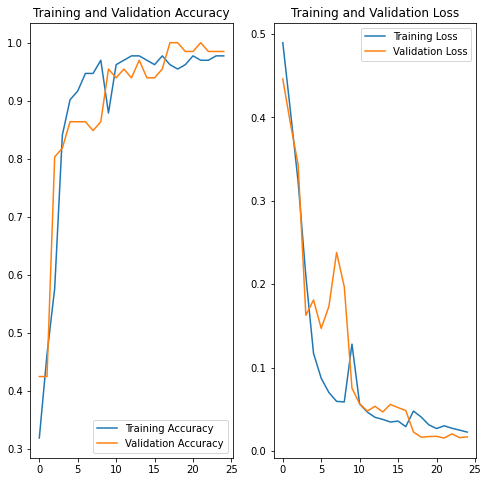

In [17]:
acc = []
val_acc = []
loss = []
val_loss = []
for history in histories:
    acc = acc + history.history['accuracy']
    val_acc = val_acc + history.history['val_accuracy']

    loss = loss + history.history['loss']
    val_loss = val_loss + history.history['val_loss']
    

epochs_range = range(len(acc))

pyplot.figure(figsize=(8, 8))
pyplot.subplot(1, 2, 1)
pyplot.plot(epochs_range, acc, label='Training Accuracy')
pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
pyplot.legend(loc='lower right')
pyplot.title('Training and Validation Accuracy')

pyplot.subplot(1, 2, 2)
pyplot.plot(epochs_range, loss, label='Training Loss')
pyplot.plot(epochs_range, val_loss, label='Validation Loss')
pyplot.legend(loc='upper right')
pyplot.title('Training and Validation Loss')
pyplot.show()

In [21]:
def to_type(one_hot_encoding):
    return sl.get_vocabulary()[np.argmax(tf.nn.softmax(one_hot_encoding))]

predictions = [ to_type(model.predict(X_test)[i]) for i in range(len(X_test)) ]
actuals = [ to_type(y_test[i]) for i in range(len(y_test)) ]

pd.DataFrame(np.array([actuals, predictions]).T, columns=["actual", "predicted"])

,actual,predicted
0,malware,malware
1,benign,benign
2,defacement,defacement
3,benign,benign
4,benign,benign
...,...,...
94,phishing,phishing
95,malware,malware
96,defacement,defacement
97,defacement,defacement


## TODO
1. Run this on the entire raw_data set
2. Do one-hot-encoding for the city, region, country, and type (probably using tensorflow/keras/sklearn)
3. Do text encoding on url and content (probably using tensorflow/keras/sklearn)
4. Split training and testing (using tensorflow/keras/sklearn)
5. Implement Z-Fold cross-validation (probably using tensorflow/keras/sklearn)
6. Train CNN using tensorflow/keras/sklearn
7. Optinally, fine tune hyperparameters (e.g. epochs, activation function, layers, etc.)
8. Graph results